#### Grab a random molecule from FreeSolv, parameterize with OpenFF 1.2.0, generate some configuration snapshots

In [1]:
import openforcefield
openforcefield.__version__

'0.8.0'

In [2]:
from openforcefield.topology import Molecule
from openforcefield.typing.engines.smirnoff import ForceField
forcefield = ForceField('openff-1.2.0.offxml')

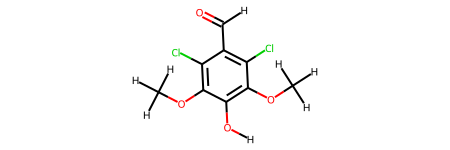

In [3]:
# random molecule from freesolv database.txt
# https://github.com/MobleyLab/FreeSolv/blob/ff0961a3177863c8002e8487ff9718c513974138/database.txt#L397
offmol = Molecule.from_smiles('COc1c(c(c(c(c1Cl)C=O)Cl)OC)O')
offmol

In [4]:
offmol.compute_partial_charges_am1bcc()

In [5]:
offmol.generate_conformers()

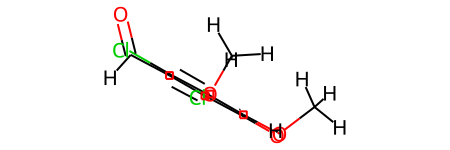

In [6]:
offmol.to_rdkit()

In [7]:
len(offmol.conformers)

1

In [8]:
sys = forcefield.create_openmm_system(offmol.to_topology())
top = offmol.to_topology().to_openmm()

In [9]:
from simtk import unit
from simtk import openmm as mm
from simtk.openmm import app


temperature = 300 * unit.kelvin
gamma = 100.0 / unit.picosecond
dt = 1.0 * unit.femtosecond

sim = app.Simulation(top, sys, mm.LangevinIntegrator(temperature, gamma, dt))

In [10]:
off_charges = offmol.partial_charges

In [11]:
nb_force = sys.getForce(0)
nb_force

<simtk.openmm.openmm.NonbondedForce; proxy of <Swig Object of type 'OpenMM::NonbondedForce *' at 0x7f8dc9970ae0> >

In [12]:
N = offmol.n_atoms
N

23

In [13]:
omm_charges = []
for i in range(N):
    omm_charges.append(nb_force.getParticleParameters(i)[0])

In [14]:
charge_differences = [omm_charges[i] - off_charges[i] for i in range(N)]
charge_differences

[Quantity(value=0.0, unit=elementary charge),
 Quantity(value=0.0, unit=elementary charge),
 Quantity(value=0.0, unit=elementary charge),
 Quantity(value=0.0, unit=elementary charge),
 Quantity(value=0.0, unit=elementary charge),
 Quantity(value=0.0, unit=elementary charge),
 Quantity(value=0.0, unit=elementary charge),
 Quantity(value=0.0, unit=elementary charge),
 Quantity(value=0.0, unit=elementary charge),
 Quantity(value=0.0, unit=elementary charge),
 Quantity(value=0.0, unit=elementary charge),
 Quantity(value=0.0, unit=elementary charge),
 Quantity(value=0.0, unit=elementary charge),
 Quantity(value=0.0, unit=elementary charge),
 Quantity(value=0.0, unit=elementary charge),
 Quantity(value=0.0, unit=elementary charge),
 Quantity(value=0.0, unit=elementary charge),
 Quantity(value=0.0, unit=elementary charge),
 Quantity(value=0.0, unit=elementary charge),
 Quantity(value=0.0, unit=elementary charge),
 Quantity(value=0.0, unit=elementary charge),
 Quantity(value=0.0, unit=elementa

In [15]:
sim.context.setPositions(offmol.conformers[0])

In [16]:
def get_energy():
    return sim.context.getState(getEnergy=True).getPotentialEnergy()

In [17]:
get_energy()

Quantity(value=258.4339904785156, unit=kilojoule/mole)

In [18]:
sim.minimizeEnergy()

In [19]:
get_energy()

Quantity(value=242.51620483398438, unit=kilojoule/mole)

In [20]:
sim.context.setVelocitiesToTemperature(temperature)

In [21]:
def get_positions():
    return sim.context.getState(getPositions=True).getPositions(asNumpy=True)

In [22]:
get_positions()

Quantity(value=array([[ 0.25787252,  0.02050192, -0.19939502],
       [ 0.20957561, -0.10400783, -0.14720073],
       [ 0.19580406, -0.10378213, -0.0098293 ],
       [ 0.29582617, -0.16354832,  0.06761356],
       [ 0.28628427, -0.16435738,  0.20790081],
       [ 0.1743831 , -0.10668242,  0.27013183],
       [ 0.07211669, -0.04751066,  0.19314739],
       [ 0.0823373 , -0.04789897,  0.0519701 ],
       [-0.04737184,  0.01389246, -0.04980485],
       [-0.04333544,  0.0122078 ,  0.26227048],
       [-0.10133274,  0.11306173,  0.22370285],
       [ 0.16506597, -0.1072682 ,  0.44578177],
       [ 0.38360867, -0.22357166,  0.28573391],
       [ 0.50545275, -0.14874387,  0.29327917],
       [ 0.40126154, -0.22257276,  0.00262366],
       [ 0.26751426,  0.01357658, -0.30817151],
       [ 0.35597834,  0.04417292, -0.15710716],
       [ 0.18885079,  0.10214639, -0.1760828 ],
       [-0.0755612 , -0.02902563,  0.35737294],
       [ 0.57527167, -0.19916944,  0.36076942],
       [ 0.48599979, -0.0

In [23]:
%%time
sim.step(10000)

CPU times: user 133 ms, sys: 76.7 ms, total: 210 ms
Wall time: 351 ms


In [24]:
from espaloma.units import DISTANCE_UNIT, ENERGY_UNIT

Using backend: pytorch


In [25]:
import torch
torch.set_default_dtype(torch.float64)

import numpy as np

In [26]:
from tqdm import tqdm
xyz = []
vacuum_energies = []

n_samples = 100

for _ in tqdm(range(n_samples)):
    sim.step(1000)
    xyz.append(get_positions().value_in_unit(DISTANCE_UNIT))
    vacuum_energies.append(get_energy().value_in_unit(ENERGY_UNIT))
vacuum_energies = torch.tensor(vacuum_energies)

100%|██████████| 100/100 [00:18<00:00,  5.47it/s]


In [27]:
print(DISTANCE_UNIT)

bohr


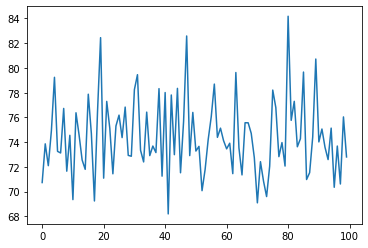

In [29]:
import matplotlib.pyplot as plt

plt.plot((vacuum_energies * ENERGY_UNIT).value_in_unit(unit.kilocalorie_per_mole))

In [30]:
N = len(xyz[0])
N

23

#### Pre-compute pairwise distance matrices

In [31]:
xyz[0]

array([[ 4.07750047,  1.19310164, -2.24069233],
       [ 2.83126061, -0.99990161, -1.38914258],
       [ 2.84925203, -1.136739  ,  1.16439308],
       [ 4.89946106, -2.42073058,  2.22278652],
       [ 4.9926773 , -2.66091966,  4.81035154],
       [ 3.21002998, -1.53427803,  6.34061352],
       [ 1.02394323, -0.26653221,  5.25903266],
       [ 0.79876944, -0.2390666 ,  2.6231183 ],
       [-1.99945645,  0.44255701,  1.1150657 ],
       [-0.80143118,  0.87860074,  6.98718225],
       [-2.63163559,  2.02944787,  6.23445141],
       [ 3.49098866, -2.00393079,  9.55052269],
       [ 6.92679559, -3.86758189,  6.06760641],
       [ 9.25812803, -2.51412479,  6.35158487],
       [ 6.89334031, -3.1087439 ,  0.72418778],
       [ 2.93529446,  2.84335636, -1.74294804],
       [ 4.31741978,  1.03912881, -4.28873212],
       [ 5.94596579,  1.5284153 , -1.42085833],
       [-0.79091579,  0.37032487,  8.97449029],
       [10.55882621, -3.88403807,  7.19256412],
       [ 9.1077961 , -0.90071353,  7.636

In [32]:
from scipy.spatial.distance import pdist, squareform

distance_matrices = [torch.tensor(squareform(pdist(conf))) for conf in xyz]
distance_matrices = torch.stack(distance_matrices)

In [33]:
(torch.median(distance_matrices[0]) * DISTANCE_UNIT).value_in_unit(unit.angstrom)

tensor(3.9548)

In [34]:
radii = (torch.ones(N) * unit.angstroms).value_in_unit(DISTANCE_UNIT)
scales = torch.ones(N)

In [35]:
radii.shape, scales.shape

(torch.Size([23]), torch.Size([23]))

In [36]:
radii, scales

(tensor([1.8897, 1.8897, 1.8897, 1.8897, 1.8897, 1.8897, 1.8897, 1.8897, 1.8897,
         1.8897, 1.8897, 1.8897, 1.8897, 1.8897, 1.8897, 1.8897, 1.8897, 1.8897,
         1.8897, 1.8897, 1.8897, 1.8897, 1.8897]),
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1.]))

In [37]:
offmol.partial_charges

Quantity(value=array([ 0.11063   , -0.32578999,  0.04101   ,  0.13609999,  0.04101   ,
        0.06506   , -0.19729   ,  0.06506   , -0.04672   ,  0.58569002,
       -0.49212   , -0.04672   , -0.32578999,  0.11063   , -0.4727    ,
        0.04844   ,  0.04844   ,  0.04844   ,  0.02066   ,  0.04844   ,
        0.04844   ,  0.04844   ,  0.44064   ]), unit=elementary charge)

In [38]:
charges = torch.tensor([c / unit.elementary_charge for c in off_charges])

#### Compute hydration free energy difference using EXP


In [39]:
from espaloma.mm.implicit import gbsa_obc2_energy

In [40]:
# TODO: jit this, bro

def compute_obc2_energies(distance_matrices, radii, scales, charges):
    N = len(distance_matrices)
    E_s = torch.zeros(N)
    for i in range(N):
        E_s[i] += gbsa_obc2_energy(
            distance_matrices[i],
            radii, scales, charges
        )
    return E_s

In [41]:
len(distance_matrices)

100

In [42]:
obc2_energies = compute_obc2_energies(distance_matrices, radii, scales, charges)

In [43]:
obc2_energies

tensor([-0.0740, -0.0770, -0.0780, -0.0747, -0.0737, -0.0749, -0.0714, -0.0748,
        -0.0730, -0.0732, -0.0750, -0.0776, -0.0759, -0.0754, -0.0753, -0.0777,
        -0.0751, -0.0745, -0.0782, -0.0776, -0.0760, -0.0734, -0.0785, -0.0754,
        -0.0760, -0.0742, -0.0804, -0.0768, -0.0790, -0.0769, -0.0775, -0.0714,
        -0.0755, -0.0748, -0.0786, -0.0778, -0.0739, -0.0742, -0.0765, -0.0734,
        -0.0733, -0.0742, -0.0751, -0.0768, -0.0736, -0.0761, -0.0776, -0.0748,
        -0.0755, -0.0720, -0.0723, -0.0752, -0.0738, -0.0743, -0.0717, -0.0720,
        -0.0725, -0.0773, -0.0745, -0.0739, -0.0756, -0.0745, -0.0761, -0.0748,
        -0.0764, -0.0732, -0.0734, -0.0722, -0.0737, -0.0735, -0.0746, -0.0759,
        -0.0742, -0.0761, -0.0727, -0.0748, -0.0732, -0.0709, -0.0710, -0.0752,
        -0.0754, -0.0755, -0.0743, -0.0733, -0.0759, -0.0768, -0.0728, -0.0771,
        -0.0784, -0.0733, -0.0759, -0.0757, -0.0740, -0.0754, -0.0716, -0.0752,
        -0.0766, -0.0721, -0.0774, -0.07

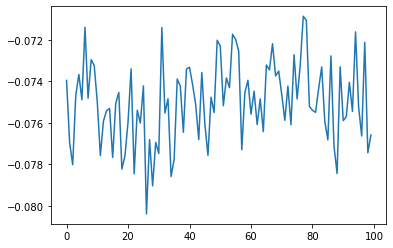

In [44]:
plt.plot(obc2_energies.detach().numpy())

In [45]:
radii

tensor([1.8897, 1.8897, 1.8897, 1.8897, 1.8897, 1.8897, 1.8897, 1.8897, 1.8897,
        1.8897, 1.8897, 1.8897, 1.8897, 1.8897, 1.8897, 1.8897, 1.8897, 1.8897,
        1.8897, 1.8897, 1.8897, 1.8897, 1.8897])

In [46]:
from openmmtools.constants import kB
kT = kB * temperature

In [47]:
to_kT = 1.0 * ENERGY_UNIT / kT
to_kT

1052.5821686494048

In [48]:
w = (obc2_energies - vacuum_energies) * to_kT
w

tensor([-196.4868, -204.8953, -203.0547, -204.2970, -210.4527, -201.7020,
        -197.8013, -207.4428, -196.9776, -202.1338, -195.2663, -209.7706,
        -205.0241, -201.0908, -199.7019, -212.3835, -204.3050, -194.5972,
        -210.5493, -219.9688, -199.2000, -206.9033, -208.5758, -199.1902,
        -206.3286, -205.9077, -209.3662, -209.7259, -205.5252, -203.2021,
        -212.8039, -208.4320, -202.5253, -200.2179, -210.9210, -204.1510,
        -201.3662, -200.8356, -211.8598, -196.7788, -208.0266, -192.4439,
        -209.5805, -203.2734, -208.8579, -200.0426, -208.5755, -217.2241,
        -201.7736, -203.9575, -199.0079, -202.6802, -195.2566, -198.6254,
        -199.9667, -203.3520, -208.3551, -206.1390, -204.4859, -202.1680,
        -202.7732, -202.3670, -199.9341, -212.3504, -203.8016, -196.7402,
        -204.0628, -202.7281, -202.9330, -199.3992, -194.4446, -201.3457,
        -196.9699, -196.8377, -197.4017, -209.9680, -205.8994, -196.7378,
        -198.8515, -200.0430, -220.560

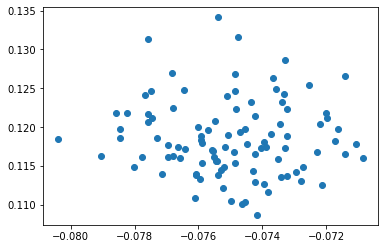

In [58]:
plt.scatter(obc2_energies, vacuum_energies)

(array([ 2.,  1.,  5.,  9., 12., 18., 22., 14., 13.,  4.]),
 array([-220.5606721 , -217.74899353, -214.93731496, -212.12563639,
        -209.31395781, -206.50227924, -203.69060067, -200.8789221 ,
        -198.06724353, -195.25556495, -192.44388638]),
 <BarContainer object of 10 artists>)

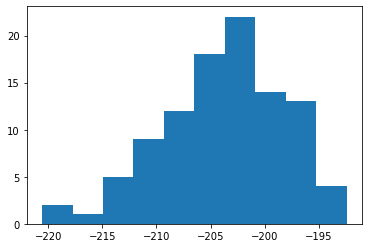

In [56]:
plt.hist(w.detach().flatten().numpy())

In [57]:
w.detach().flatten().numpy().std()

5.611685430423913

In [59]:
def one_sided_exp(w):
    DeltaF = - (torch.logsumexp(- w, dim=(0,)) - np.log(len(w)))
    return DeltaF

In [60]:
%%time
one_sided_exp(w)

CPU times: user 745 µs, sys: 514 µs, total: 1.26 ms
Wall time: 764 µs


tensor(-216.4211)

In [61]:
((one_sided_exp(w) / to_kT).detach() * ENERGY_UNIT).value_in_unit(unit.kilocalorie_per_mole)

tensor(-129.0220)

#### TODO: huh, fishy that this is off by so much... Initial prediction is a hydration free energy of -120-130 kcal/mol????

#### TODO: double-check against timemachine implementation and against openmm implementation

In [62]:
expt_delta_f = -8.68 * unit.kilocalorie_per_mole / kT
expt_delta_f

-14.559801248448967

In [63]:
radii.requires_grad_()
scales.requires_grad_()

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1.], requires_grad=True)

In [64]:
sum([c.value_in_unit(unit.elementary_charge) for c in off_charges])

1.6763806343078613e-08

In [65]:
#def free_energy_loss(distance_matrices, radii, scales, charges):
#    w = compute_obc2_energies(distance_matrices, radii, scales, charges) - vacuum_energies
#    pred_delta_f = one_sided_exp(w)
#    return torch.sqrt((pred_delta_f - expt_delta_f)**2)

In [66]:
# NOTE: compilation time blows up because it attempts to inline the entire
# loop over the training data...
#fast_free_energy_loss = torch.jit.trace(
#    free_energy_loss,
#    (distance_matrices, radii, scales, charges),
#)

In [67]:
def free_energy_loss(radii, scales, charges, inds):
    """compute hydration free energy using the subset of snapshots indexed by inds"""
    solv_energies = compute_obc2_energies(distance_matrices[inds], radii, scales, charges)
    w = solv_energies - vacuum_energies[inds]
    pred_delta_f = one_sided_exp(w)
    return torch.sqrt((pred_delta_f - expt_delta_f)**2)

#### Check ability to fit to expt free energy target if all radii and scales are free parameters

In [68]:
radii = (torch.ones(N) * unit.angstroms).value_in_unit(DISTANCE_UNIT)
scales = torch.ones(N)
radii, scales

(tensor([1.8897, 1.8897, 1.8897, 1.8897, 1.8897, 1.8897, 1.8897, 1.8897, 1.8897,
         1.8897, 1.8897, 1.8897, 1.8897, 1.8897, 1.8897, 1.8897, 1.8897, 1.8897,
         1.8897, 1.8897, 1.8897, 1.8897, 1.8897]),
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1.]))

In [69]:
radii.requires_grad_()
scales.requires_grad_()

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1.], requires_grad=True)

In [70]:
learning_rate = 1e-3
optimizer = torch.optim.Adam([radii, scales], lr=learning_rate)

In [71]:
distance_matrices.shape

torch.Size([100, 23, 23])

In [72]:
radii_traj = [np.array(radii.detach().numpy())]
scales_traj = [np.array(scales.detach().numpy())]

n_snapshots_per_batch = 25
batch_losses = []
trange = tqdm(range(1000))
for t in trange:
    batch_inds = np.random.choice(range(len(distance_matrices)), n_snapshots_per_batch)
    L = free_energy_loss(radii, scales, charges, batch_inds)
    
    optimizer.zero_grad()
    L.backward()
    optimizer.step()
    
    batch_losses.append(L.detach().numpy())
    trange.set_postfix(batch_loss=batch_losses[-1])
    
    
    radii_traj.append(np.array(radii.detach().numpy()))
    scales_traj.append(np.array(scales.detach().numpy()))

100%|██████████| 1000/1000 [00:51<00:00, 19.24it/s, batch_loss=8.215375274837115]


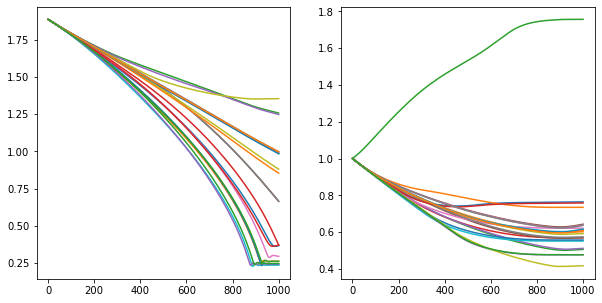

In [74]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(np.array(radii_traj))
plt.subplot(1,2,2)
plt.plot(np.array(scales_traj))

In [75]:
loss_traj_in_kcalmol = [(b * kT).value_in_unit(unit.kilocalorie_per_mole) for b in batch_losses]

(0.0, 8.748730838938133)

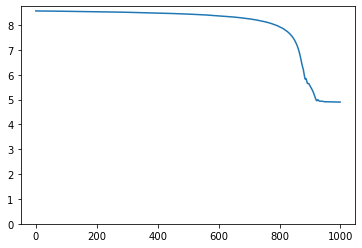

In [76]:
plt.plot(loss_traj_in_kcalmol)
plt.ylim(0,)

#### Double-check estimate variance under configuration subsampling

In [77]:
losses = []
for _ in tqdm(range(1000)):
    batch_inds = np.random.choice(range(len(distance_matrices)), n_snapshots_per_batch)
    L = float(free_energy_loss(radii, scales, charges, batch_inds).detach())
    losses.append(L)

100%|██████████| 1000/1000 [00:23<00:00, 43.47it/s]


Text(0, 0.5, 'frequency')

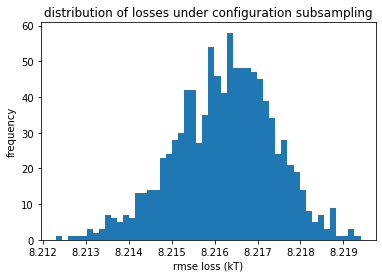

In [78]:
plt.title('distribution of losses under configuration subsampling')
plt.hist(losses, bins=50);
plt.xlabel('rmse loss (kT)')
plt.ylabel('frequency')

#### Now let's get a graph net in the mix!

In [94]:
from espaloma.redux.nn import TAG, MLP
from espaloma.redux.symmetry import ValenceModel, Readouts, elements

def initialize(hidden_dim=128, node_dim=128):
    node_representation = TAG(in_dim=len(elements), hidden_dim=hidden_dim, out_dim=node_dim)
    readouts = Readouts(atoms=MLP(node_dim, 2), bonds=MLP(2 * node_dim, 2), angles=MLP(3 * node_dim, 2),
                        propers=MLP(4 * node_dim, 6), impropers=MLP(4 * node_dim, 6))
    valence_model = ValenceModel(node_representation, readouts)
    return valence_model

In [95]:
valence_model = initialize()

In [96]:
params = valence_model.forward(offmol)

In [97]:
radii = params.atoms[:,0]
scales = params.atoms[:,1]
radii, scales

(tensor([0.0443, 0.0476, 0.0470, 0.0531, 0.0470, 0.0538, 0.0493, 0.0538, 0.0411,
         0.0496, 0.0466, 0.0411, 0.0476, 0.0443, 0.0400, 0.0593, 0.0593, 0.0593,
         0.0566, 0.0593, 0.0593, 0.0593, 0.0446], grad_fn=<SelectBackward>),
 tensor([0.0420, 0.0623, 0.0443, 0.0476, 0.0443, 0.0616, 0.0575, 0.0616, 0.0606,
         0.0400, 0.0657, 0.0606, 0.0623, 0.0420, 0.0324, 0.0596, 0.0596, 0.0596,
         0.0639, 0.0596, 0.0596, 0.0596, 0.0502], grad_fn=<SelectBackward>))

In [98]:
def predict_obc2_params(offmol):
    """output of graph net's atom representation will initially be near zero, just offset by +1"""
    params = valence_model.forward(offmol)
    radii = params.atoms[:,0] + 1
    scales = params.atoms[:,1] + 1
    return radii, scales

In [103]:
radii, scales = predict_obc2_params(offmol)
radii, scales

(tensor([0.3677, 0.2594, 0.4371, 0.3356, 0.4371, 0.4776, 0.2965, 0.4776, 0.5755,
         0.2333, 0.2400, 0.5755, 0.2594, 0.3677, 0.2415, 0.5779, 0.5779, 0.5779,
         0.4158, 0.5779, 0.5779, 0.5779, 0.2446], grad_fn=<AddBackward0>),
 tensor([0.6393, 0.4575, 0.6248, 0.5358, 0.6248, 0.6518, 0.5147, 0.6518, 0.7243,
         0.5125, 0.4892, 0.7243, 0.4575, 0.6393, 0.5009, 0.6476, 0.6476, 0.6476,
         0.6059, 0.6476, 0.6476, 0.6476, 0.4781], grad_fn=<AddBackward0>))

In [100]:
learning_rate = 1e-4
optimizer = torch.optim.Adam(valence_model.parameters(), lr=learning_rate)

In [101]:
radii_traj = [np.array(radii.detach().numpy())]
scales_traj = [np.array(scales.detach().numpy())]

batch_losses = []
trange = tqdm(range(1000))

n_snapshots_per_batch = 5

for t in trange:
    batch_inds = np.random.choice(range(len(distance_matrices)), n_snapshots_per_batch)
    
    radii, scales = predict_obc2_params(offmol)
    L = free_energy_loss(radii, scales, charges, batch_inds)
    
    optimizer.zero_grad()
    L.backward()
    optimizer.step()
    
    batch_losses.append(L.detach().numpy())
    trange.set_postfix(batch_loss=batch_losses[-1])
    
    
    radii_traj.append(np.array(radii.detach().numpy()))
    scales_traj.append(np.array(scales.detach().numpy()))

100%|██████████| 1000/1000 [00:38<00:00, 25.80it/s, batch_loss=8.223368918225177]


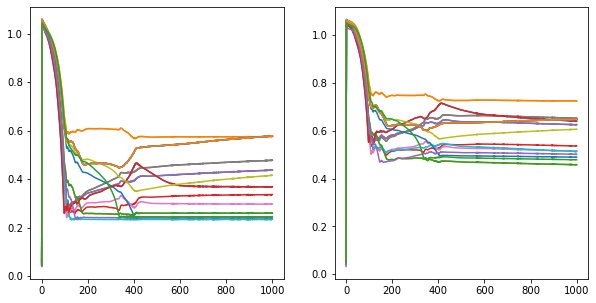

In [102]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(np.array(radii_traj))
plt.subplot(1,2,2)
plt.plot(np.array(scales_traj))

Text(0, 0.5, 'hydration free energy error (kcal/mol)')

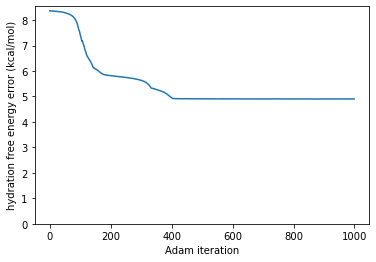

In [106]:
loss_traj_in_kcalmol = [(b * kT).value_in_unit(unit.kilocalorie_per_mole) for b in batch_losses]
plt.plot(loss_traj_in_kcalmol)
plt.ylim(0,)
plt.xlabel('Adam iteration')
plt.ylabel('hydration free energy error (kcal/mol)')